In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

2025-08-20 08:57:27.269025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755680247.433671      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755680247.483984      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = "/kaggle/input/data-256-256-new/data_256_256_new"

In [3]:
df = pd.read_excel(f"{base_dir}/labels.xlsx")

# full file paths
df["filepath"] = df["id"].apply(lambda x: os.path.join(base_dir, x))
print(df.head())

                id label                                           filepath
0  Red/Red (1).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
1  Red/Red (2).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
2  Red/Red (3).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
3  Red/Red (4).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
4  Red/Red (5).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...


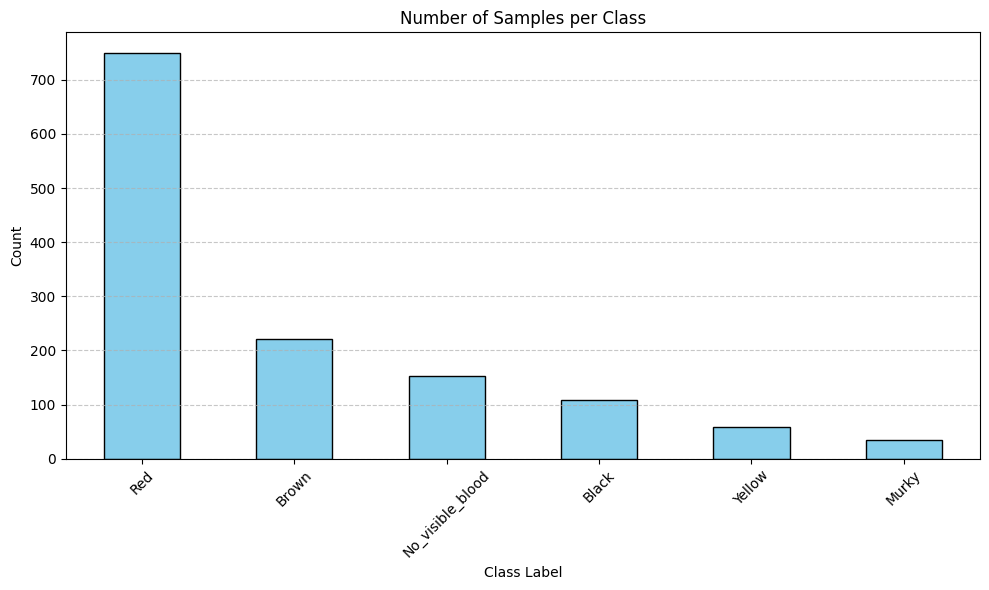

In [4]:
class_counts = df['label'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Samples per Class')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Pre-Processing

In [4]:
print("Loading images...")
images = []
labels = []
for i, row in df.iterrows():
    try:
        img = load_img(row["filepath"], target_size=(256, 256))
        img_array = img_to_array(img) / 255.0  # normalize
        images.append(img_array)
        labels.append(row["label"])
        
        if (i + 1) % 100 == 0:
            print(f"Loaded {i + 1} images.")
    except Exception as e:
        print(f"Error loading {row['filepath']}: {e}")

Loading images...
Loaded 100 images.
Loaded 200 images.
Loaded 300 images.
Loaded 400 images.
Loaded 500 images.
Loaded 600 images.
Loaded 700 images.
Loaded 800 images.
Loaded 900 images.
Loaded 1000 images.
Loaded 1100 images.
Loaded 1200 images.
Loaded 1300 images.


In [5]:
images = np.array(images)
labels = np.array(labels)
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

Images shape: (1325, 256, 256, 3), Labels shape: (1325,)


In [6]:
images[1]

array([[[0.84705883, 0.62352943, 0.59607846],
        [0.83137256, 0.60784316, 0.5803922 ],
        [0.80784315, 0.5803922 , 0.5647059 ],
        ...,
        [0.81960785, 0.80784315, 0.84313726],
        [0.827451  , 0.8156863 , 0.85882354],
        [0.83137256, 0.81960785, 0.8627451 ]],

       [[0.75686276, 0.5254902 , 0.5019608 ],
        [0.7529412 , 0.52156866, 0.49803922],
        [0.75686276, 0.5254902 , 0.50980395],
        ...,
        [0.76862746, 0.75686276, 0.78431374],
        [0.7882353 , 0.7647059 , 0.8039216 ],
        [0.7882353 , 0.7764706 , 0.8117647 ]],

       [[0.68235296, 0.42745098, 0.40392157],
        [0.69411767, 0.4392157 , 0.41568628],
        [0.7137255 , 0.45882353, 0.44313726],
        ...,
        [0.7411765 , 0.7254902 , 0.7294118 ],
        [0.7607843 , 0.7372549 , 0.7529412 ],
        [0.7647059 , 0.74509805, 0.7607843 ]],

       ...,

       [[0.5803922 , 0.5137255 , 0.4862745 ],
        [0.5882353 , 0.52156866, 0.49019608],
        [0.59607846, 0

In [7]:
# Encode labels
le = LabelEncoder()
labels_int = le.fit_transform(labels)
labels_onehot = to_categorical(labels_int)

print("Integer labels (first 5):", labels_int[:5])
print("One-hot labels (first 5):", labels_onehot[:5])
print("Classes:", le.classes_)

num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")

Integer labels (first 5): [4 4 4 4 4]
One-hot labels (first 5): [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]
Classes: ['Black' 'Brown' 'Murky' 'No_visible_blood' 'Red' 'Yellow']
Number of classes: 6


## Split

In [8]:
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test, labels_temp, labels_test = train_test_split(
    images, labels_onehot, labels_int, 
    test_size=0.2, random_state=42, stratify=labels_int
)

In [9]:
X_train, X_val, y_train, y_val, labels_train, labels_val = train_test_split(
    X_temp, y_temp, labels_temp,
    test_size=0.25, random_state=42, stratify=labels_temp  
)

In [10]:
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (795, 256, 256, 3), (795, 6)
Validation set: (265, 256, 256, 3), (265, 6)
Test set: (265, 256, 256, 3), (265, 6)


In [11]:
print("\nTraining set class distribution:")
train_class_counts = Counter(labels_train)
for class_idx, count in sorted(train_class_counts.items()):
    class_name = le.classes_[class_idx]
    print(f"{class_name}: {count} samples")


Training set class distribution:
Black: 65 samples
Brown: 134 samples
Murky: 20 samples
No_visible_blood: 92 samples
Red: 450 samples
Yellow: 34 samples


## Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=20,          # Random rotations up to 20 degrees
    width_shift_range=0.1,      # Horizontal shifts up to 10%
    height_shift_range=0.1,     # Vertical shifts up to 10%
    shear_range=0.1,           # Shearing transformation
    zoom_range=0.1,            # Random zoom in/out
    horizontal_flip=True,       # Random horizontal flips
    fill_mode='nearest'         # Fill pixels after transformation
)

In [15]:
val_datagen = ImageDataGenerator()

In [16]:
batch_size = 32
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

## Model

In [17]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

In [18]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2., alpha=.25),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755680327.729288      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755680327.729929      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,267,398 (50.61 MB)

 Trainable params: 13,267,398 (50.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Set up callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

In [20]:
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

In [21]:
history = model.fit(
    train_generator,                    # Use generator instead of X_train, y_train
    steps_per_epoch=steps_per_epoch,    # Number of batches per epoch
    validation_data=val_generator,      # Use generator for validation
    validation_steps=validation_steps,  # Number of validation batches
    epochs=30, 
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1755680342.367058     105 service.cc:148] XLA service 0x7fa0a0003af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755680342.367642     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755680342.367665     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755680342.742844     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/24 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.1953 - loss: 0.3167 

I0000 00:00:1755680349.860117     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.4516 - loss: 0.2461
Epoch 1: val_accuracy improved from -inf to 0.56641, saving model to best_model.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 710ms/step - accuracy: 0.4541 - loss: 0.2451 - val_accuracy: 0.5664 - val_loss: 0.1838
Epoch 2/30
 1/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5938 - loss: 0.1959

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.56641
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5938 - loss: 0.1959 - val_accuracy: 0.5547 - val_loss: 0.1824
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.5233 - loss: 0.1839
Epoch 3: val_accuracy did not improve from 0.56641
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step - accuracy: 0.5236 - loss: 0.1839 - val_accuracy: 0.5586 - val_loss: 0.1528
Epoch 4/30
 1/24 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5000 - loss: 0.1786
Epoch 4: val_accuracy improved from 0.56641 to 0.58984, saving model to best_model.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5000 - loss: 0.1786 - val_accuracy: 0.5898 - val_loss: 0.1471
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5152 - loss: 0.1653
Epoch 5: val_accuracy improved from 0.58984 to 0.63672, saving model to best_model.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - accuracy: 0.5172 - loss: 0.1652 - val_accuracy: 0.6367 - val_loss: 0.1443

In [22]:
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Train Accuracy: {accuracy*100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.6528 - loss: 0.1202
Train Accuracy: 63.65%


In [23]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6592 - loss: 0.1283
Validation Accuracy: 66.79%


## Loss and Accuracy Matrices

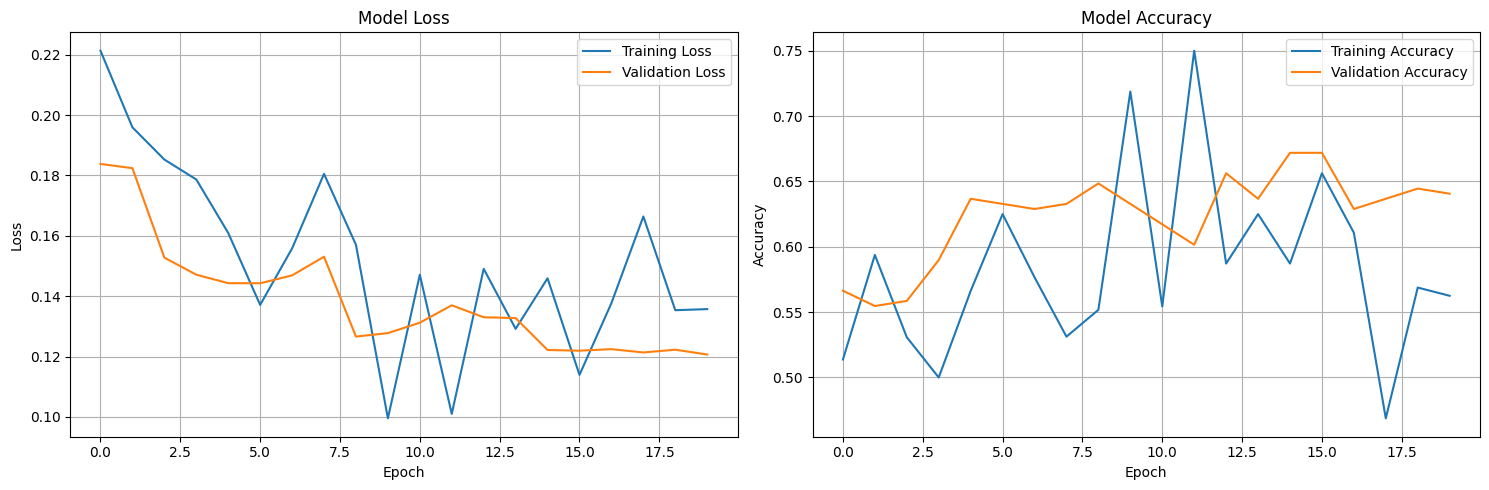

In [24]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Other Matrices

In [29]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5', custom_objects={'focal_loss_fixed': focal_loss(gamma=2., alpha=.25)})

In [30]:
# Make predictions on all sets
train_preds = np.argmax(best_model.predict(X_train), axis=1)
val_preds = np.argmax(best_model.predict(X_val), axis=1)
test_preds = np.argmax(best_model.predict(X_test), axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [31]:
# Convert one-hot labels back to integers for comparison
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)
y_test_int = np.argmax(y_test, axis=1)

In [32]:
# Calculate accuracies
train_accuracy = np.mean(y_train_int == train_preds)
val_accuracy = np.mean(y_val_int == val_preds)
test_accuracy = np.mean(y_test_int == test_preds)

In [33]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.6365
Validation Accuracy: 0.6679
Test Accuracy: 0.6642


In [34]:
from sklearn.metrics import classification_report

In [35]:
# Detailed classification report for test set
print("\n=== Train Set Classification Report ===")
print(classification_report(y_train_int, train_preds, target_names=le.classes_))


=== Train Set Classification Report ===
                  precision    recall  f1-score   support

           Black       0.00      0.00      0.00        65
           Brown       0.46      0.16      0.23       134
           Murky       0.00      0.00      0.00        20
No_visible_blood       0.38      0.96      0.54        92
             Red       0.77      0.88      0.82       450
          Yellow       0.00      0.00      0.00        34

        accuracy                           0.64       795
       macro avg       0.27      0.33      0.27       795
    weighted avg       0.55      0.64      0.57       795



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# Detailed classification report for test set
print("\n=== Validation Set Classification Report ===")
print(classification_report(y_val_int, val_preds, target_names=le.classes_))


=== Validation Set Classification Report ===
                  precision    recall  f1-score   support

           Black       0.00      0.00      0.00        22
           Brown       0.69      0.20      0.32        44
           Murky       0.00      0.00      0.00         7
No_visible_blood       0.37      0.97      0.54        30
             Red       0.80      0.93      0.86       150
          Yellow       0.00      0.00      0.00        12

        accuracy                           0.67       265
       macro avg       0.31      0.35      0.29       265
    weighted avg       0.61      0.67      0.60       265



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# Detailed classification report for test set
print("\n=== Test Set Classification Report ===")
print(classification_report(y_test_int, test_preds, target_names=le.classes_))


=== Test Set Classification Report ===
                  precision    recall  f1-score   support

           Black       0.00      0.00      0.00        22
           Brown       0.65      0.25      0.36        44
           Murky       0.00      0.00      0.00         7
No_visible_blood       0.37      0.90      0.52        30
             Red       0.79      0.92      0.85       150
          Yellow       0.00      0.00      0.00        12

        accuracy                           0.66       265
       macro avg       0.30      0.34      0.29       265
    weighted avg       0.60      0.66      0.60       265



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

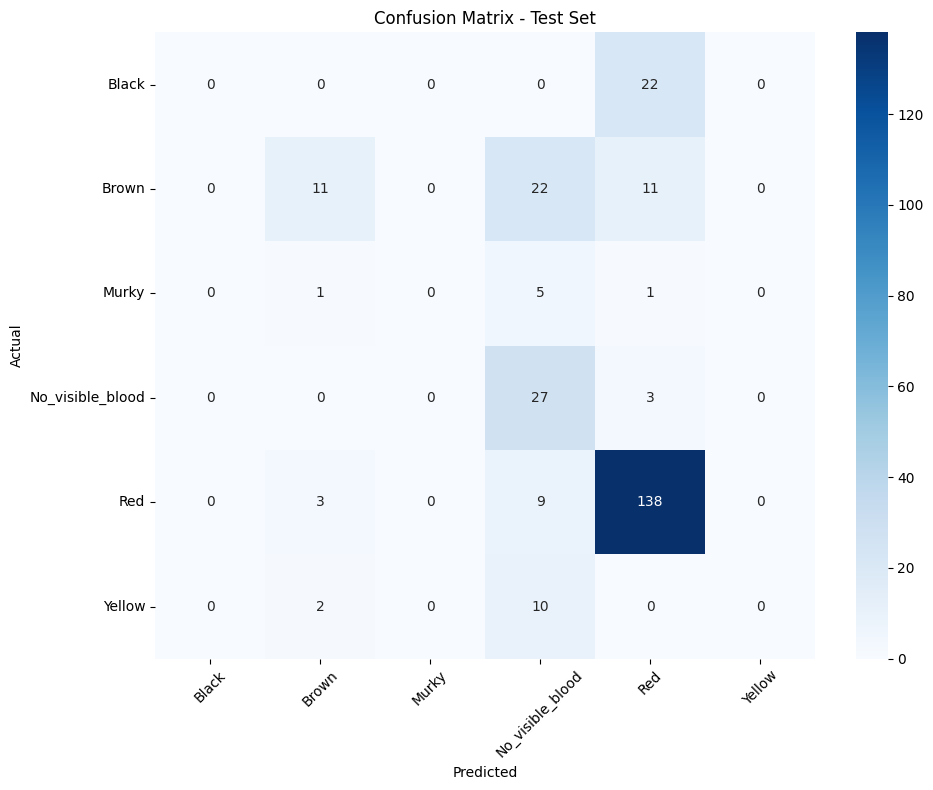

In [39]:
# Confusion Matrix for test set
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_int, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()